In [1]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


In [2]:
import keras
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from PIL import Image
import matplotlib.pyplot as plt

In [3]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('/content/cats_and_dogs.zip', origin=URL, extract=True)
!unzip '/content/cats_and_dogs.zip'

train_path = '/content/cats_and_dogs_filtered/train'
valid_path = '/content/cats_and_dogs_filtered/validation'

68616192/68606236 [==============================] - 0s 0us/step
Archive:  /content/cats_and_dogs.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jp

(500, 374)


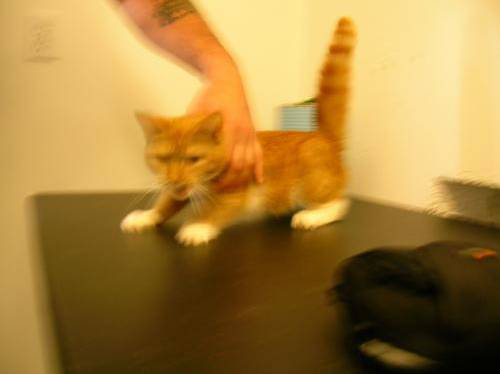

In [4]:
# Show image
img = Image.open('/content/cats_and_dogs_filtered/train/cats/cat.0.jpg')
print(img.size)
display(img)

In [5]:
# Data pre-processing
Datagen = ImageDataGenerator(rotation_range=20,
                horizontal_flip=True, 
                fill_mode='nearest') 

train_generator = Datagen.flow_from_directory(train_path, target_size=(224,224), classes=['cats', 'dogs'])
valid_generator = Datagen.flow_from_directory(valid_path, target_size=(224,224), classes=['cats', 'dogs'])

print(train_generator.image_shape)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
(224, 224, 3)


In [6]:
# Target neural network
vgg16_model = VGG16()
vgg16_model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [7]:
# Build my neural network
model = Sequential()

for layer in vgg16_model.layers[:-1]: # We don't need a prediction layer
    layer.trainable = False # The model is already trained, no need to adjust the weights again
    model.add(layer)

model.add(Dense(2, activation='softmax', name="my_predictions")) # Because we only have two types of cats and dogs to predict

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [8]:
LR_function=ReduceLROnPlateau(monitor='val_accuracy',
                patience=1,  # 1 epochs 內acc沒下降就要調整LR
                verbose=1,
                factor=0.75, # new_LR = LR * 0.75
                min_lr=1e-8 # 最小 LR 到1e-8就不再下降     
                ) 

In [9]:
# Model compile and train
model.compile(Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_generator, validation_data=valid_generator, callbacks=[LR_function], epochs=10, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
63/63 - 54s - loss: 0.3862 - accuracy: 0.8305 - val_loss: 0.2205 - val_accuracy: 0.9090 - lr: 1.0000e-04 - 54s/epoch - 865ms/step
Epoch 2/10
63/63 - 39s - loss: 0.1680 - accuracy: 0.9315 - val_loss: 0.1563 - val_accuracy: 0.9340 - lr: 1.0000e-04 - 39s/epoch - 614ms/step
Epoch 3/10
63/63 - 40s - loss: 0.1408 - accuracy: 0.9485 - val_loss: 0.1494 - val_accuracy: 0.9450 - lr: 1.0000e-04 - 40s/epoch - 642ms/step
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-05.
63/63 - 47s - loss: 0.1262 - accuracy: 0.9475 - val_loss: 0.1412 - val_accuracy: 0.9380 - lr: 1.0000e-04 - 47s/epoch - 738ms/step
Epoch 5/10
63/63 - 39s - loss: 0.1195 - accuracy: 0.9510 - val_loss: 0.1216 - val_accuracy: 0.9540 - lr: 7.5000e-05 - 39s/epoch - 621ms/step
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.6249997214763425e-05.
63/63 - 40s - loss: 0.1128 - accuracy: 0.9540 - val_loss: 0.1288 - val_accuracy: 0.9470 - lr: 7.5000e-05 - 40s/epoch - 633ms/step

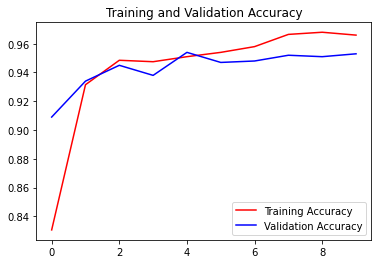

Accuracy mean:0.9421499967575073.
Validation accuracy mean:0.9431000053882599.


In [10]:
epochs=range(10)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs,acc,'r-',label='Training Accuracy')
plt.plot(epochs,val_acc,'b-',label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

print(f"Accuracy mean:{np.mean(acc)}.")
print(f"Validation accuracy mean:{np.mean(val_acc)}.")

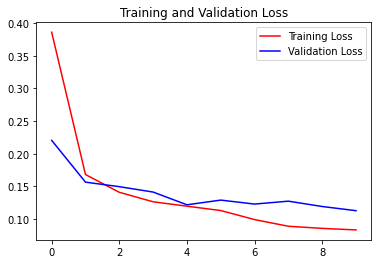

Loss mean:0.14097786843776702.
Validation loss mean:0.13993237316608428.


In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs,loss,'r-',label='Training Loss')
plt.plot(epochs,val_loss,'b-',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print(f"Loss mean:{np.mean(loss)}.")
print(f"Validation loss mean:{np.mean(val_loss)}.")

#Save and Load

In [12]:
model.save("cat-dog-model-base-VGG16.h5")

In [13]:
load_model = keras.models.load_model("cat-dog-model-base-VGG16.h5")
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

#Prediction

(459, 499)


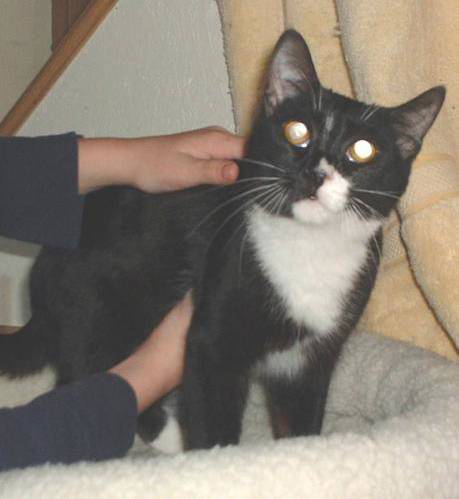

In [14]:
# Show image
img = Image.open('/content/cats_and_dogs_filtered/validation/cats/cat.2000.jpg')
print(img.size)
display(img)

In [15]:
def predict_label(list):
  if list[0][0] > list[0][1]:
    return "Cat"
  return "Dog"

Cat


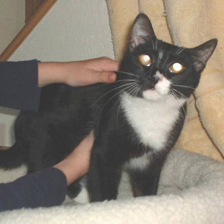

In [16]:
# 圖片縮放寬高為 (224, 224) 
img = img.resize((224, 224))

# 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# 特徵縮放，每個特徵減掉該特徵的平均數
x = preprocess_input(x)

print(predict_label(model.predict(x)))
display(img)